Aug 22nd, 2025


Author: Opal Issan (oissan@ucsd.edu)

In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import wofz 
import scipy
import math
from QLT_equations.general_plasma_equations import Z_prime, I, Z

In [3]:
%matplotlib inline
import matplotlib
font = {'family' : 'sans-serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

In [4]:
# normalization
# time is normalized to the electron cyclotron frequency
# space is normalized to electron inertial length d_e

# match the values in khazanov et al. The nonlinear coupling of electromagnetic ion cyclotron and lower hybrid

# cold electron density
ne = 1  # ne
# cold He+ density
nHe = 0  # ne
# cold O+ density
nO = 0.1 # ne
# hot proton density
npH = 0.1  # ne
# cold proton density
npC = 1 - npH - nO - nHe  # ne

# mass ratios
mp_me = 100  # dimensionless
mO_mp = 16  # dimensionless
mHe_mp = 4  # dimensionless

omega_pe = 2 # Omega_ce

# assume the plasma is isothermal Te=Tp=TO+=THe+
alpha_c_perp = np.sqrt(1e-4)  # d_e x Omega_ce
alpha_c_par = alpha_c_perp  # d_e x Omega_ce
alpha_p_par = alpha_c_perp / np.sqrt(mp_me)  # d_e x Omega_ce
alpha_He_par = alpha_c_perp / np.sqrt(mp_me * mHe_mp)  # de x Omega_ce
alpha_O_par = alpha_c_perp / np.sqrt(mp_me * mO_mp)  # de x Omega_ce

wLH = 1/np.sqrt(mp_me) # Omega_ce
rhoe = alpha_c_perp/np.sqrt(2) # de 

# relative drift is what matters
UDp = -3 * alpha_p_par / np.sqrt(2)
UDO = 10 * alpha_p_par / np.sqrt(2)
UDHe = 0. * alpha_p_par / np.sqrt(2)

# dispersion relation 

\begin{align*}
    1 - \frac{\omega_{pe}^2}{\omega^2 }\cos(\theta_{k})^2 + \frac{\omega_{pe}^2}{\Omega_{ce}^2} \sin(\theta_{k})^2
    = \sum_{s=\{He^{+}, O^{+}, p\}}\frac{\omega_{ps}^2}{\alpha_{\| s}^2 |\vec{k}|^2}  Z' \left( \frac{\omega - k_{\perp} U_{x, Ds}}{\alpha_{\| s} |\vec{k}|}\right).
\end{align*}

In [5]:
def cold_electron_response(k_, omega, omega_pe_, theta_):
    k_perp = np.sin(theta_) * k_ 
    k_par = np.cos(theta_) * k_ 
    return - (np.cos(theta_)**2) * (omega_pe_**2)/(omega**2) + omega_pe_**2 * (np.sin(theta_)**2)

def ion_response(omega_pi_, alpha_i_, k_, theta_, v_0_, n_, omega):
    k_perp = np.sin(theta_) * k_ 
    k_par = np.cos(theta_) * k_ 
    return n_ * (omega_pi_ ** 2) / (alpha_i_ ** 2) / (k**2) * Z_prime(z=(omega - k_perp * v_0_) / (alpha_i_ * np.abs(k)))

In [6]:
def disp_k_(k,
            theta,
            npC_=npC,
            nO_=nO,
            nHe_=nHe,
            omega_pe_=omega_pe,
            mp_me_=mp_me,
            mO_mp_=mO_mp,
            mHe_mp_=mHe_mp,
            VDp_=UDp,
            VDHe_=UDHe,
            VDO_=UDO,
            alpha_p_par_=alpha_p_par,
            alpha_O_par_=alpha_O_par,
            alpha_He_par_=alpha_He_par):
    return lambda omega: 1 + cold_electron_response(k_=k, omega=omega, omega_pe_=omega_pe_, theta_=theta) \
                         - ion_response(omega_pi_=omega_pe_ / np.sqrt(mp_me_), n_=npC_, alpha_i_=alpha_p_par_,
                                        v_0_=VDp_, omega=omega, k_=k, theta_=theta) \
                         - ion_response(omega_pi_=omega_pe_ / np.sqrt(mp_me_ * mO_mp_), n_=nO_,
                                        alpha_i_=alpha_O_par_, k_=k, v_0_=VDO_, omega=omega, theta_=theta) \
                         - ion_response(omega_pi_=omega_pe_ / np.sqrt(mp_me_ * mHe_mp_), n_=nHe_,
                                        alpha_i_=alpha_He_par_, k_=k, v_0_=VDHe_, omega=omega, theta_=theta)

# Ion-ion current-driven instability 
\begin{equation*}
    k_{\perp} \approx
\frac{\omega_{\mathrm{LH}} \sqrt{c_{cp}}}{U_{x, DO+}}\qquad \mathrm{and} \qquad \omega_{r} = \left[1 - \frac{1}{2^{\frac{4}{3}}} \left[\frac{c_{O+}}{c_{cp}} \frac{m_{p}}{ m_{O+}} \right]^{\frac{1}{3}} \right] \omega_{\mathrm{LH}} \sqrt{c_{cp}}.
\end{equation*}

In [7]:
k =  np.sqrt(npC)*wLH/UDO # de
angle = 0
theta = np.pi/2 - angle * np.pi/ 180
omega_guess = np.sqrt(npC) * (1 - 1/(2**(4/3)) * ((nO/npC / mO_mp)**(1/3))) * wLH  # Omega_ce


sol_approx = scipy.optimize.newton(disp_k_(k=k, theta=theta), omega_guess + 0.005j, tol=1e-16, 
                                   maxiter=10000, x1=omega_guess*0.99 + 1e-2j)
print(sol_approx)
print("omega_k + i gamma = ", sol_approx/wLH)
print("dispersion residual = ", disp_k_(k=k, theta=theta)(sol_approx))

(0.05660492403671557+1.652339965093076e-15j)
omega_k + i gamma =  (0.5660492403671556+1.652339965093076e-14j)
dispersion residual =  (3.9968028886505635e-14+1.724064501638112e-13j)


In [8]:
k_ii = np.abs(np.linspace(0.5, 6, 40) * np.sqrt(npC) * wLH /UDO) # d_e
theta_ii = np.pi/2 - np.linspace(0, 180, 20)*np.pi/180

sol_ii = np.zeros((len(theta_ii), len(k_ii)), dtype="complex128") * np.nan

In [ ]:
for ii in range(len(k_ii)):
    for jj in range(len(theta_ii)):
        try:
            sol_ii[ii, jj] = scipy.optimize.newton(disp_k_(k=k_ii[ii], theta=theta_ii[jj]), 
                                                 omega_guess + 0.005j, tol=1e-16, maxiter=10000, 
                                                   x1=omega_guess*2 + 1e-2j)
            
            error = abs(disp_k_(k=k_ii[ii], theta=theta_ii[jj])(sol_ii[ii, jj]))
            print("dispersion residual = ", error)
            if error > 1e-10:
                sol_ii[ii, jj] = np.nan
        except:
            print("An exception occurred")

/Users/oissan/PycharmProjects/EMIC_secondary_instability/QLT_equations/general_plasma_equations.py:19: RuntimeWarning: invalid value encountered in scalar multiply
  return 1j * np.sqrt(np.pi) * wofz(z)
/opt/anaconda3/envs/rom/lib/python3.9/site-packages/scipy/optimize/_zeros_py.py:382: RuntimeWarning: invalid value encountered in scalar divide
  p = (-q1 / q0 * p0 + p1) / (1 - q1 / q0)
/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_25561/3181228115.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return - (np.cos(theta_)**2) * (omega_pe_**2)/(omega**2) + omega_pe_**2 * (np.sin(theta_)**2)
/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_25561/3181228115.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return - (np.cos(theta_)**2) * (omega_pe_**2)/(omega**2) + omega_pe_**2 * (np.sin(theta_)**2)
/opt/anaconda3/envs/rom/lib/python3.9/site-packages/scipy/optimize/_zeros_py.py:382: RuntimeWarning: invalid value encountered in scalar

An exception occurred
dispersion residual =  1.5987213803903003e-14
dispersion residual =  5.718938002884741e-15
dispersion residual =  9.681149132352316e-14
dispersion residual =  4.440892504426519e-16
dispersion residual =  1.3325120274873716e-15
dispersion residual =  1.3322987290402383e-15
dispersion residual =  1.121325288469318e-14
dispersion residual =  1.1324274859105258e-14
dispersion residual =  3.3308164258621454e-16
dispersion residual =  5.551136256407657e-15
dispersion residual =  3.3306694437441907e-16
dispersion residual =  2.220446049250313e-16
dispersion residual =  1.2878587085775456e-14
dispersion residual =  1.9984027769786945e-15
dispersion residual =  2.666463768745607e-15
dispersion residual =  4.440892137916306e-16
dispersion residual =  3.512273282459248e-14
dispersion residual =  1.0658158882114276e-14
dispersion residual =  3.870453242135827e-14
An exception occurred
dispersion residual =  3.1086736972236938e-15
dispersion residual =  7.061018437183306e-14
d

/Users/oissan/PycharmProjects/EMIC_secondary_instability/QLT_equations/general_plasma_equations.py:19: RuntimeWarning: invalid value encountered in scalar multiply
  return 1j * np.sqrt(np.pi) * wofz(z)
/opt/anaconda3/envs/rom/lib/python3.9/site-packages/scipy/optimize/_zeros_py.py:382: RuntimeWarning: invalid value encountered in scalar divide
  p = (-q1 / q0 * p0 + p1) / (1 - q1 / q0)
/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_25561/3181228115.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return - (np.cos(theta_)**2) * (omega_pe_**2)/(omega**2) + omega_pe_**2 * (np.sin(theta_)**2)


dispersion residual =  0.0
dispersion residual =  7.549516593874667e-15
dispersion residual =  1.88738096094507e-15
dispersion residual =  5.073816438899542e-16
dispersion residual =  1.1213252582621593e-14
dispersion residual =  9.45846064854825e-17
dispersion residual =  1.0769163338864018e-14
dispersion residual =  1.4654944839870973e-14
dispersion residual =  2.226705996334337e-15
dispersion residual =  2.220446049250313e-16
dispersion residual =  1.0080825063596421e-13
dispersion residual =  1.0214051836046407e-14
dispersion residual =  4.505772098603303e-16
dispersion residual =  6.628126747819992e-14
dispersion residual =  6.953849680587847e-13
dispersion residual =  4.049046671930593
dispersion residual =  8.038014750879434e-14
dispersion residual =  9.325889484994565e-15
dispersion residual =  1.1546319690375763e-14
dispersion residual =  3.996803175922044e-15
dispersion residual =  7.949196856316121e-14
dispersion residual =  4.192228759612883e-19
dispersion residual =  3.885

/Users/oissan/PycharmProjects/EMIC_secondary_instability/QLT_equations/general_plasma_equations.py:19: RuntimeWarning: invalid value encountered in scalar multiply
  return 1j * np.sqrt(np.pi) * wofz(z)
/opt/anaconda3/envs/rom/lib/python3.9/site-packages/scipy/optimize/_zeros_py.py:382: RuntimeWarning: invalid value encountered in scalar divide
  p = (-q1 / q0 * p0 + p1) / (1 - q1 / q0)
/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_25561/3181228115.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return - (np.cos(theta_)**2) * (omega_pe_**2)/(omega**2) + omega_pe_**2 * (np.sin(theta_)**2)


An exception occurred
dispersion residual =  1.7941204122393365e-13
dispersion residual =  7.1063370362496e-15
dispersion residual =  1.1546319609456002e-14
dispersion residual =  1.3322676295501878e-15
dispersion residual =  1.0658141036401503e-14
dispersion residual =  8.917199143562822e-16
dispersion residual =  2.7773968546609688e-15
dispersion residual =  4.447277066228599e-16
dispersion residual =  1.110223102955739e-16
dispersion residual =  2.220446049250313e-16
dispersion residual =  1.1102230246251565e-16
dispersion residual =  7.771561351115883e-15
dispersion residual =  8.881784197001252e-14
dispersion residual =  5.128808707391978e-15
dispersion residual =  1.0658141036401503e-14
dispersion residual =  1.117112379934522e-17
dispersion residual =  1.6431300830150874e-14
dispersion residual =  1.2436318302415136e-14
dispersion residual =  5.506760004112054e-13
An exception occurred
dispersion residual =  7.727152253865055e-14
dispersion residual =  7.54951665859543e-15
dispe

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_25561/3181228115.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return - (np.cos(theta_)**2) * (omega_pe_**2)/(omega**2) + omega_pe_**2 * (np.sin(theta_)**2)
/opt/anaconda3/envs/rom/lib/python3.9/site-packages/scipy/optimize/_zeros_py.py:382: RuntimeWarning: invalid value encountered in scalar divide
  p = (-q1 / q0 * p0 + p1) / (1 - q1 / q0)
/Users/oissan/PycharmProjects/EMIC_secondary_instability/QLT_equations/general_plasma_equations.py:19: RuntimeWarning: invalid value encountered in scalar multiply
  return 1j * np.sqrt(np.pi) * wofz(z)


dispersion residual =  1.0880185641326534e-14
dispersion residual =  7.99360578422202e-15
dispersion residual =  1.332267635775243e-15
dispersion residual =  5.529923355048013e-14
dispersion residual =  8.881784322966854e-16
dispersion residual =  8.594227462162692e-13
An exception occurred
dispersion residual =  3.108624482193542e-15
dispersion residual =  1.9539925233566526e-14
dispersion residual =  9.325873456912123e-15
dispersion residual =  3.1086265901626675e-15
dispersion residual =  0.0
dispersion residual =  8.881784218800889e-16
dispersion residual =  8.559819585894231e-14
dispersion residual =  4.441126642287953e-16
dispersion residual =  1.1102597090094622e-16
dispersion residual =  3.3306749904044924e-15
dispersion residual =  1.00225389096246e-15
dispersion residual =  0.0
dispersion residual =  4.440892291567073e-16
dispersion residual =  6.663903205203878e-16
dispersion residual =  8.926193117986259e-14
dispersion residual =  3.99680290068337e-15
dispersion residual = 

/Users/oissan/PycharmProjects/EMIC_secondary_instability/QLT_equations/general_plasma_equations.py:19: RuntimeWarning: invalid value encountered in scalar multiply
  return 1j * np.sqrt(np.pi) * wofz(z)
/opt/anaconda3/envs/rom/lib/python3.9/site-packages/scipy/optimize/_zeros_py.py:382: RuntimeWarning: invalid value encountered in scalar divide
  p = (-q1 / q0 * p0 + p1) / (1 - q1 / q0)
/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_25561/3181228115.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return - (np.cos(theta_)**2) * (omega_pe_**2)/(omega**2) + omega_pe_**2 * (np.sin(theta_)**2)


dispersion residual =  1.5404242884727624e-15
dispersion residual =  7.815970678950696e-14
dispersion residual =  7.993606356987892e-15
dispersion residual =  4.440897899253196e-16
dispersion residual =  1.0658141036401542e-14
dispersion residual =  9.880986627709735e-15
dispersion residual =  1.1102230246251565e-14
dispersion residual =  1.1102253046170482e-16
dispersion residual =  8.903988657493755e-14
dispersion residual =  1.1102230246251565e-16
dispersion residual =  3.1114963397684027e-15
dispersion residual =  4.440892098500626e-16
dispersion residual =  6.661347541952191e-16
dispersion residual =  2.2204462711866865e-15
dispersion residual =  6.261657859135135e-14
dispersion residual =  1.831133995105655e-14
dispersion residual =  8.6694774094946335e-16
dispersion residual =  3.5971487863986695e-13
An exception occurred
dispersion residual =  1.239464675023676e-13
dispersion residual =  8.61284877689008e-15
dispersion residual =  4.440892098509651e-16
dispersion residual =  8.

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_25561/3181228115.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return - (np.cos(theta_)**2) * (omega_pe_**2)/(omega**2) + omega_pe_**2 * (np.sin(theta_)**2)
/opt/anaconda3/envs/rom/lib/python3.9/site-packages/scipy/optimize/_zeros_py.py:382: RuntimeWarning: invalid value encountered in scalar divide
  p = (-q1 / q0 * p0 + p1) / (1 - q1 / q0)


An exception occurred

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_25561/3181228115.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return - (np.cos(theta_)**2) * (omega_pe_**2)/(omega**2) + omega_pe_**2 * (np.sin(theta_)**2)
/opt/anaconda3/envs/rom/lib/python3.9/site-packages/scipy/optimize/_zeros_py.py:382: RuntimeWarning: invalid value encountered in scalar divide
  p = (-q1 / q0 * p0 + p1) / (1 - q1 / q0)



dispersion residual =  8.215650387608797e-14
dispersion residual =  1.1102230246252531e-14
dispersion residual =  9.326937837125306e-15
dispersion residual =  2.664899159878872e-15
dispersion residual =  1.3323034668288333e-15
dispersion residual =  5.240324652148761e-20
dispersion residual =  8.104628079823536e-15
dispersion residual =  2.4611113377201403e-15
dispersion residual =  7.771562312108535e-16
dispersion residual =  1.5543124983655801e-15
dispersion residual =  1.1102244598850822e-16
dispersion residual =  1.0880185641326534e-14
dispersion residual =  8.892478717996893e-16
dispersion residual =  4.663681800578441e-15
dispersion residual =  8.881811068975362e-16
dispersion residual =  6.2172495204044126e-15
dispersion residual =  1.3363231272001222e-15
dispersion residual =  3.2862613389742985e-14
dispersion residual =  2.30260679363903e-12
dispersion residual =  3.6259689730350213
dispersion residual =  1.0658609401449019e-13
dispersion residual =  4.308296182245116e-15
dis

/Users/oissan/PycharmProjects/EMIC_secondary_instability/QLT_equations/general_plasma_equations.py:19: RuntimeWarning: invalid value encountered in scalar multiply
  return 1j * np.sqrt(np.pi) * wofz(z)
/opt/anaconda3/envs/rom/lib/python3.9/site-packages/scipy/optimize/_zeros_py.py:382: RuntimeWarning: invalid value encountered in scalar divide
  p = (-q1 / q0 * p0 + p1) / (1 - q1 / q0)
/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_25561/3181228115.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return - (np.cos(theta_)**2) * (omega_pe_**2)/(omega**2) + omega_pe_**2 * (np.sin(theta_)**2)
/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_25561/3181228115.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return - (np.cos(theta_)**2) * (omega_pe_**2)/(omega**2) + omega_pe_**2 * (np.sin(theta_)**2)
/opt/anaconda3/envs/rom/lib/python3.9/site-packages/scipy/optimize/_zeros_py.py:382: RuntimeWarning: invalid value encountered in scalar

An exception occurred
dispersion residual =  2.5717148170891853e-13
dispersion residual =  2.2000807181194123e-15
dispersion residual =  5.195113912415539e-18
dispersion residual =  1.7763568394002505e-15
dispersion residual =  9.769962616726544e-15
dispersion residual =  1.776356863929898e-15
dispersion residual =  5.551266650993822e-16
dispersion residual =  8.859579736512142e-14
dispersion residual =  5.551117690756004e-16
dispersion residual =  2.220446049250313e-16
dispersion residual =  3.3306690738754696e-16
dispersion residual =  8.881791796322341e-16
dispersion residual =  4.441204389983604e-16
dispersion residual =  1.1102269485745663e-15
dispersion residual =  4.440892098500626e-16
dispersion residual =  1.1990612217683393e-14
dispersion residual =  6.261756416381172e-14
dispersion residual =  2.9237443091065125e-15
dispersion residual =  4.636291546432802e-12


/Users/oissan/PycharmProjects/EMIC_secondary_instability/QLT_equations/general_plasma_equations.py:19: RuntimeWarning: invalid value encountered in scalar multiply
  return 1j * np.sqrt(np.pi) * wofz(z)
/opt/anaconda3/envs/rom/lib/python3.9/site-packages/scipy/optimize/_zeros_py.py:382: RuntimeWarning: invalid value encountered in scalar divide
  p = (-q1 / q0 * p0 + p1) / (1 - q1 / q0)
/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_25561/3181228115.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return - (np.cos(theta_)**2) * (omega_pe_**2)/(omega**2) + omega_pe_**2 * (np.sin(theta_)**2)
/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_25561/3181228115.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return - (np.cos(theta_)**2) * (omega_pe_**2)/(omega**2) + omega_pe_**2 * (np.sin(theta_)**2)
/opt/anaconda3/envs/rom/lib/python3.9/site-packages/scipy/optimize/_zeros_py.py:382: RuntimeWarning: invalid value encountered in scalar

An exception occurred
dispersion residual =  1.007885705430822e-13
dispersion residual =  4.442974623838718e-16
dispersion residual =  4.4408932377656395e-15
dispersion residual =  4.497965725082941e-16
dispersion residual =  1.2434497955219085e-14
dispersion residual =  4.441018743744416e-16
dispersion residual =  2.99920901255163e-15
dispersion residual =  1.1102230308303252e-15
dispersion residual =  1.165772284778968e-14
dispersion residual =  4.512890466105165e-19
dispersion residual =  1.1102230246251565e-16
dispersion residual =  1.1103733556888204e-15
dispersion residual =  4.912847806906971e-21
dispersion residual =  9.992010056675557e-15
dispersion residual =  9.330782100876941e-15
dispersion residual =  7.682743333587197e-14
dispersion residual =  6.6613419039547695e-15
dispersion residual =  5.1071023242493295e-14
dispersion residual =  1.4028861116135907e-13


/Users/oissan/PycharmProjects/EMIC_secondary_instability/QLT_equations/general_plasma_equations.py:19: RuntimeWarning: invalid value encountered in scalar multiply
  return 1j * np.sqrt(np.pi) * wofz(z)


An exception occurred
dispersion residual =  5.595532129187659e-14
dispersion residual =  9.903189475678223e-14
dispersion residual =  1.2878587103946938e-14
dispersion residual =  6.2172489464890475e-15
dispersion residual =  8.881784197001252e-16
dispersion residual =  4.440892098500628e-16
dispersion residual =  8.848477506262498e-14
dispersion residual =  5.995216648400623e-15
dispersion residual =  1.1102230246251565e-16
dispersion residual =  2.2223723009555294e-16
dispersion residual =  1.1102254268727406e-16
dispersion residual =  8.881785311533433e-16
dispersion residual =  4.440892216857929e-16
dispersion residual =  6.661338147750939e-16
dispersion residual =  2.220452334783792e-15
dispersion residual =  8.526512841634966e-14
dispersion residual =  7.549516730450979e-14
dispersion residual =  4.130030991805871e-14
dispersion residual =  5.706546348937419e-13


/Users/oissan/PycharmProjects/EMIC_secondary_instability/QLT_equations/general_plasma_equations.py:19: RuntimeWarning: invalid value encountered in scalar multiply
  return 1j * np.sqrt(np.pi) * wofz(z)
/opt/anaconda3/envs/rom/lib/python3.9/site-packages/scipy/optimize/_zeros_py.py:382: RuntimeWarning: invalid value encountered in scalar divide
  p = (-q1 / q0 * p0 + p1) / (1 - q1 / q0)
/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_25561/3181228115.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return - (np.cos(theta_)**2) * (omega_pe_**2)/(omega**2) + omega_pe_**2 * (np.sin(theta_)**2)
/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_25561/3181228115.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return - (np.cos(theta_)**2) * (omega_pe_**2)/(omega**2) + omega_pe_**2 * (np.sin(theta_)**2)
/opt/anaconda3/envs/rom/lib/python3.9/site-packages/scipy/optimize/_zeros_py.py:382: RuntimeWarning: invalid value encountered in scalar

An exception occurred
dispersion residual =  1.154631948578509e-14
dispersion residual =  4.654054919228656e-13
dispersion residual =  7.061018437481583e-14
dispersion residual =  4.4410233217192205e-16
dispersion residual =  1.3323714228834027e-15
dispersion residual =  8.881784197001254e-15
dispersion residual =  3.446039167714941e-16
dispersion residual =  7.793765632868599e-14
dispersion residual =  3.3306690738754696e-16
dispersion residual =  0.0
dispersion residual =  1.1879387738560695e-14
dispersion residual =  1.2884230636733011e-14
dispersion residual =  4.440892098500626e-16
dispersion residual =  2.220592796506728e-16
dispersion residual =  4.884981392806571e-15
dispersion residual =  1.1102232460349622e-14
dispersion residual =  8.659741241155014e-14
dispersion residual =  2.273301838941302e-12
dispersion residual =  7.283065091789616e-13


/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_25561/3181228115.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return - (np.cos(theta_)**2) * (omega_pe_**2)/(omega**2) + omega_pe_**2 * (np.sin(theta_)**2)
/opt/anaconda3/envs/rom/lib/python3.9/site-packages/scipy/optimize/_zeros_py.py:382: RuntimeWarning: invalid value encountered in scalar divide
  p = (-q1 / q0 * p0 + p1) / (1 - q1 / q0)


An exception occurred
dispersion residual =  1.1457501857291964e-13
dispersion residual =  1.7280317351002787e-13
dispersion residual =  7.105428125750176e-15
dispersion residual =  2.222138244744273e-15
dispersion residual =  4.440900334637114e-16
dispersion residual =  1.3766781662488897e-14
dispersion residual =  3.3306839297545515e-16
dispersion residual =  2.2398281850191486e-16


/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_25561/3181228115.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return - (np.cos(theta_)**2) * (omega_pe_**2)/(omega**2) + omega_pe_**2 * (np.sin(theta_)**2)
/opt/anaconda3/envs/rom/lib/python3.9/site-packages/scipy/optimize/_zeros_py.py:382: RuntimeWarning: invalid value encountered in scalar divide
  p = (-q1 / q0 * p0 + p1) / (1 - q1 / q0)
/Users/oissan/PycharmProjects/EMIC_secondary_instability/QLT_equations/general_plasma_equations.py:19: RuntimeWarning: invalid value encountered in scalar multiply
  return 1j * np.sqrt(np.pi) * wofz(z)


dispersion residual =  9.999373785789435e-16
dispersion residual =  8.88178568508683e-16
dispersion residual =  2.7947758828500905e-15
dispersion residual =  2.4431170287420894e-15
dispersion residual =  8.92619311798628e-14
dispersion residual =  6.883382833055453e-15
dispersion residual =  2.220448279184655e-15
dispersion residual =  1.0214425451476314e-14
dispersion residual =  1.0785029317583763e-14
dispersion residual =  1.5225307745174403e-12
dispersion residual =  8.82924721494026e-13
An exception occurred
dispersion residual =  7.105430647598472e-15
dispersion residual =  2.5757174372686902e-14
dispersion residual =  1.3766765611025012e-14
dispersion residual =  5.773300511952583e-15
dispersion residual =  2.1820401914291085e-20
dispersion residual =  8.88296833149689e-16
dispersion residual =  1.1102230246251565e-16
dispersion residual =  5.995204357250466e-15


/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_25561/3181228115.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return - (np.cos(theta_)**2) * (omega_pe_**2)/(omega**2) + omega_pe_**2 * (np.sin(theta_)**2)
/opt/anaconda3/envs/rom/lib/python3.9/site-packages/scipy/optimize/_zeros_py.py:382: RuntimeWarning: invalid value encountered in scalar divide
  p = (-q1 / q0 * p0 + p1) / (1 - q1 / q0)


dispersion residual =  3.3306690851380816e-16
dispersion residual =  4.406890829194653e-22


/Users/oissan/PycharmProjects/EMIC_secondary_instability/QLT_equations/general_plasma_equations.py:19: RuntimeWarning: invalid value encountered in scalar multiply
  return 1j * np.sqrt(np.pi) * wofz(z)
/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_25561/3181228115.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return - (np.cos(theta_)**2) * (omega_pe_**2)/(omega**2) + omega_pe_**2 * (np.sin(theta_)**2)
/opt/anaconda3/envs/rom/lib/python3.9/site-packages/scipy/optimize/_zeros_py.py:382: RuntimeWarning: invalid value encountered in scalar divide
  p = (-q1 / q0 * p0 + p1) / (1 - q1 / q0)


dispersion residual =  2.109423812635134e-15
dispersion residual =  8.881787529067112e-16
dispersion residual =  2.664553535122158e-15
dispersion residual =  2.2267880707914366e-16
dispersion residual =  9.947598312965182e-14
dispersion residual =  4.432010314303625e-13
dispersion residual =  7.105526812632642e-15
dispersion residual =  5.537792474118804e-13
dispersion residual =  7.266178929335717e-13
An exception occurred
dispersion residual =  7.771561173387203e-14
dispersion residual =  3.218344867404965e-14
dispersion residual =  3.6548541970660153e-13
dispersion residual =  1.9539925254601492e-14
dispersion residual =  2.6645352782558816e-15
dispersion residual =  2.3536728122392002e-14
dispersion residual =  1.1104021076185394e-16
dispersion residual =  5.8508879932321696e-18
dispersion residual =  1.221245372085819e-15
dispersion residual =  6.968396259251534e-21
dispersion residual =  1.0003110364317034e-13
dispersion residual =  2.2204460492533364e-16
dispersion residual =  5

/Users/oissan/PycharmProjects/EMIC_secondary_instability/QLT_equations/general_plasma_equations.py:19: RuntimeWarning: invalid value encountered in scalar multiply
  return 1j * np.sqrt(np.pi) * wofz(z)


dispersion residual =  3.330670501713852e-16
dispersion residual =  4.440893815843365e-16
dispersion residual =  1.3322771268673613e-15
dispersion residual =  1.110223246559592e-15
dispersion residual =  3.108671479811466e-15
dispersion residual =  1.33227820291087e-15
dispersion residual =  7.993621465434965e-15
dispersion residual =  7.27765787483345e-12
dispersion residual =  7.847171279415341e-15
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_25561/3181228115.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return - (np.cos(theta_)**2) * (omega_pe_**2)/(omega**2) + omega_pe_**2 * (np.sin(theta_)**2)
/opt/anaconda3/envs/rom/lib/python3.9/site-packages/scipy/optimize/_zeros_py.py:382: RuntimeWarning: invalid value encountered in scalar divide
  p = (-q1 / q0 * p0 + p1) / (1 - q1 / q0)


An exception occurred
An exception occurred


/Users/oissan/PycharmProjects/EMIC_secondary_instability/QLT_equations/general_plasma_equations.py:19: RuntimeWarning: invalid value encountered in scalar multiply
  return 1j * np.sqrt(np.pi) * wofz(z)


An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred


/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_25561/3181228115.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return - (np.cos(theta_)**2) * (omega_pe_**2)/(omega**2) + omega_pe_**2 * (np.sin(theta_)**2)
/opt/anaconda3/envs/rom/lib/python3.9/site-packages/scipy/optimize/_zeros_py.py:382: RuntimeWarning: invalid value encountered in scalar divide
  p = (-q1 / q0 * p0 + p1) / (1 - q1 / q0)


An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred


/Users/oissan/PycharmProjects/EMIC_secondary_instability/QLT_equations/general_plasma_equations.py:19: RuntimeWarning: invalid value encountered in scalar multiply
  return 1j * np.sqrt(np.pi) * wofz(z)
/opt/anaconda3/envs/rom/lib/python3.9/site-packages/scipy/optimize/_zeros_py.py:382: RuntimeWarning: invalid value encountered in scalar divide
  p = (-q1 / q0 * p0 + p1) / (1 - q1 / q0)
/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_25561/3181228115.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return - (np.cos(theta_)**2) * (omega_pe_**2)/(omega**2) + omega_pe_**2 * (np.sin(theta_)**2)


An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred


/Users/oissan/PycharmProjects/EMIC_secondary_instability/QLT_equations/general_plasma_equations.py:19: RuntimeWarning: invalid value encountered in scalar multiply
  return 1j * np.sqrt(np.pi) * wofz(z)
/opt/anaconda3/envs/rom/lib/python3.9/site-packages/scipy/optimize/_zeros_py.py:382: RuntimeWarning: invalid value encountered in scalar divide
  p = (-q1 / q0 * p0 + p1) / (1 - q1 / q0)
/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_25561/3181228115.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return - (np.cos(theta_)**2) * (omega_pe_**2)/(omega**2) + omega_pe_**2 * (np.sin(theta_)**2)
/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_25561/3181228115.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return - (np.cos(theta_)**2) * (omega_pe_**2)/(omega**2) + omega_pe_**2 * (np.sin(theta_)**2)
/opt/anaconda3/envs/rom/lib/python3.9/site-packages/scipy/optimize/_zeros_py.py:382: RuntimeWarning: invalid value encountered in scalar

In [ ]:
fig, ax = plt.subplots(figsize=(6, 3))
pos = ax.pcolormesh(k_ii*rhoe, theta_ii*180/np.pi, sol_ii.real / wLH, vmin=0, vmax=2.5)
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel(r'$\frac{\omega_{r}}{|\Omega_{LH}|}$', labelpad=20, rotation=0, fontsize=20)
ax.set_xlabel(r'$k\rho_{e}$', fontsize=15)
ax.set_ylabel(r'$\theta$ [deg.]', fontsize=15)
#ax.set_xticks([180, 200, 220, 240])
#ax.set_xlim(175, 245)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid(alpha=0.5)
plt.tight_layout()

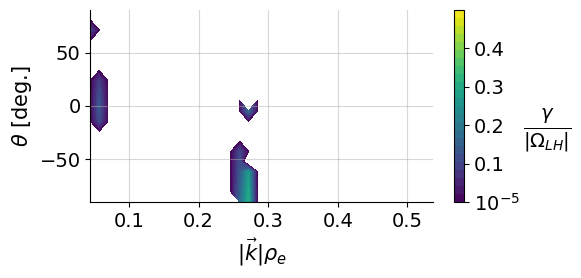

In [39]:
fig, ax = plt.subplots(figsize=(6, 3))
pos = ax.contourf(k_ii*rhoe, theta_ii*180/np.pi, sol_ii.imag / wLH, vmin=1E-5, vmax=0.5, 
                  levels=np.linspace(1e-5, 0.5, 25))

cbar = fig.colorbar(pos)
cbar.set_ticks([1e-5, 0.1, 0.2, 0.3, 0.4])
cbar.set_ticklabels(["$10^{-5}$", "0.1", "0.2", "0.3", "0.4"])

cbar.ax.set_ylabel(r'$\frac{\gamma}{|\Omega_{LH}|}$', labelpad=20, rotation=0, fontsize=20)
ax.set_xlabel(r'$|\vec{k}|\rho_{e}$', fontsize=15)
ax.set_ylabel(r'$\theta$ [deg.]', fontsize=15)


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid(alpha=0.5)
plt.tight_layout()
#plt.savefig("../../figs/vadim_2021/vadim_fig5_a.png", dpi=300, bbox_inches='tight')

Text(0.5, 1.0, '$\\theta = -\\pi/2$')

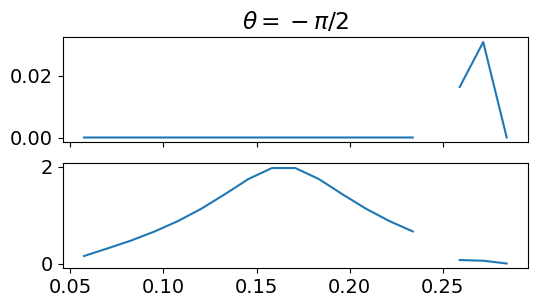

In [40]:
fig, ax = plt.subplots(nrows=2, figsize=(6, 3), sharex=True)
ax[0].plot(k_ii*rhoe, sol_ii.imag[-1, :])
ax[1].plot(k_ii*rhoe, sol_ii.real[-1, :])
ax[0].set_title(r"$\theta = -\pi/2$")

# MTSI 

\begin{equation*}
    k_{\perp} = \frac{\omega_{\mathrm{LH}} \sqrt{c_{cp}}}{U_{x, Dp}} \qquad \mathrm{and} \qquad \omega_{r} = \frac{1}{2^{\frac{4}{3}}} \left[\frac{m_{p}}{m_{e}} \sqrt{c_{cp}}\cos^2(\theta_{k})\right]^{\frac{1}{3}} \omega_{\mathrm{LH}}.
\end{equation*}

In [13]:
# quick check
k = wLH * np.sqrt(npC) / UDp   # d_e
angle = 10
theta = np.pi/2 + angle *np.pi/180


omega_guess = 1/(2**(3/4)) * ((mp_me * np.sqrt(npC)*np.cos(theta)**2)**(1/3)) *wLH # Omega_ce

sol_approx = scipy.optimize.newton(disp_k_(k=k, theta=theta), 
                                   omega_guess + 0.005j, tol=1e-16,
                                   maxiter=1000,
                                   x1=omega_guess * 1.2 + 1e-2j)
print(sol_approx)
print("k_perp rho_{e}", k*np.sin(theta)*alpha_c_perp/np.sqrt(2))
print("omega_k + i gamma = ", sol_approx * np.sqrt(mp_me))
print("dispersion residual approx = ", abs(disp_k_(k=k, theta=theta)(sol_approx)) )

(0.11366869951251858-0.01022506441240654j)
k_perp rho_{e} -0.880838832201648
omega_k + i gamma =  (1.136686995125186-0.1022506441240654j)
dispersion residual approx =  1.380694104652217e-15


In [21]:
k_mtsi = np.abs(np.linspace(0.02, 5, 30) * wLH * np.sqrt(npC) / UDp) # d_e
theta_mtsi = np.pi/2 - np.linspace(0, 20, 10)*np.pi/180
sol_mtsi = np.ones((len(k_mtsi), len(theta_mtsi)), dtype="complex128") * np.nan

In [22]:
for ii in range(len(k_mtsi)):
    for jj in range(len(theta_mtsi)):
        try:
            sol_mtsi[ii, jj] = scipy.optimize.newton(disp_k_(k=k_mtsi[ii], theta=theta_mtsi[jj]),  
                                                     omega_guess + 0.005j, 
                                                 tol=1e-16, maxiter=1000, x1=omega_guess*1.2 + 1e-2j)
            
            error = abs(disp_k_(k=k_mtsi[ii], theta=theta_mtsi[jj])(sol_mtsi[ii, jj]))
            print("dispersion residual = ", error)
            if error > 1e-8:
                sol_mtsi[ii, jj] = np.nan
        except:
            print("An exception occurred")

dispersion residual =  4.874938415636936
An exception occurred


/Users/oissan/PycharmProjects/EMIC_secondary_instability/QLT_equations/general_plasma_equations.py:19: RuntimeWarning: invalid value encountered in scalar multiply
  return 1j * np.sqrt(np.pi) * wofz(z)
/opt/anaconda3/envs/rom/lib/python3.9/site-packages/scipy/optimize/_zeros_py.py:382: RuntimeWarning: invalid value encountered in scalar divide
  p = (-q1 / q0 * p0 + p1) / (1 - q1 / q0)
/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_25299/3181228115.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return - (np.cos(theta_)**2) * (omega_pe_**2)/(omega**2) + omega_pe_**2 * (np.sin(theta_)**2)
/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_25299/3181228115.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return - (np.cos(theta_)**2) * (omega_pe_**2)/(omega**2) + omega_pe_**2 * (np.sin(theta_)**2)
/opt/anaconda3/envs/rom/lib/python3.9/site-packages/scipy/optimize/_zeros_py.py:382: RuntimeWarning: invalid value encountered in scalar

An exception occurred
dispersion residual =  1.840743518095086e-15
dispersion residual =  5.568469113035176e-16
dispersion residual =  1.1254238522216531e-15
dispersion residual =  1.5619812318275588e-15
dispersion residual =  1.7786478833195628e-15
dispersion residual =  1.331958589928774e-15
dispersion residual =  1.114694559569123e-16
An exception occurred
An exception occurred


/Users/oissan/PycharmProjects/EMIC_secondary_instability/QLT_equations/general_plasma_equations.py:19: RuntimeWarning: invalid value encountered in scalar multiply
  return 1j * np.sqrt(np.pi) * wofz(z)
/opt/anaconda3/envs/rom/lib/python3.9/site-packages/scipy/optimize/_zeros_py.py:382: RuntimeWarning: invalid value encountered in scalar divide
  p = (-q1 / q0 * p0 + p1) / (1 - q1 / q0)
/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_25299/3181228115.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return - (np.cos(theta_)**2) * (omega_pe_**2)/(omega**2) + omega_pe_**2 * (np.sin(theta_)**2)


An exception occurred
dispersion residual =  2.1124831510613762e-15
dispersion residual =  3.0064814812012657e-16
dispersion residual =  1.454638882676481e-15
dispersion residual =  1.6666330439541794e-15
dispersion residual =  3.443764206925887e-15
dispersion residual =  2.1103456479804814e-15
dispersion residual =  3.165101203371907e-15
An exception occurred
An exception occurred


/Users/oissan/PycharmProjects/EMIC_secondary_instability/QLT_equations/general_plasma_equations.py:19: RuntimeWarning: invalid value encountered in scalar multiply
  return 1j * np.sqrt(np.pi) * wofz(z)
/opt/anaconda3/envs/rom/lib/python3.9/site-packages/scipy/optimize/_zeros_py.py:382: RuntimeWarning: invalid value encountered in scalar divide
  p = (-q1 / q0 * p0 + p1) / (1 - q1 / q0)
/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_25299/3181228115.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return - (np.cos(theta_)**2) * (omega_pe_**2)/(omega**2) + omega_pe_**2 * (np.sin(theta_)**2)


An exception occurred
dispersion residual =  1.1322097734007351e-15
dispersion residual =  7.46052112072549e-16
dispersion residual =  3.6361806878608475e-16
dispersion residual =  2.1989640815351016e-16
dispersion residual =  1.997904292524575e-15
dispersion residual =  8.901368704725147e-16
dispersion residual =  5.053274732257962e-16
dispersion residual =  4.232638626463969
An exception occurred
An exception occurred
dispersion residual =  5.797195660796456e-16
dispersion residual =  4.441239029644353e-15
dispersion residual =  2.986581270449538e-15
dispersion residual =  4.655997890311777e-15
dispersion residual =  2.884392095660308e-15
dispersion residual =  2.055722238312234e-15
dispersion residual =  2.3859084584223993e-15
dispersion residual =  4.32731506550277


/Users/oissan/PycharmProjects/EMIC_secondary_instability/QLT_equations/general_plasma_equations.py:19: RuntimeWarning: invalid value encountered in scalar multiply
  return 1j * np.sqrt(np.pi) * wofz(z)
/opt/anaconda3/envs/rom/lib/python3.9/site-packages/scipy/optimize/_zeros_py.py:382: RuntimeWarning: invalid value encountered in scalar divide
  p = (-q1 / q0 * p0 + p1) / (1 - q1 / q0)
/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_25299/3181228115.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return - (np.cos(theta_)**2) * (omega_pe_**2)/(omega**2) + omega_pe_**2 * (np.sin(theta_)**2)
/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_25299/3181228115.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return - (np.cos(theta_)**2) * (omega_pe_**2)/(omega**2) + omega_pe_**2 * (np.sin(theta_)**2)
/opt/anaconda3/envs/rom/lib/python3.9/site-packages/scipy/optimize/_zeros_py.py:382: RuntimeWarning: invalid value encountered in scalar

An exception occurred
dispersion residual =  1.842612791380831e-15
dispersion residual =  1.366874039204073e-15
dispersion residual =  1.547373340571312e-15
dispersion residual =  1.716587549445839e-15
dispersion residual =  2.6617871964925677e-15
dispersion residual =  5.700726362501655e-16
dispersion residual =  8.364005478440089e-16
dispersion residual =  1.1640177912973675e-15
An exception occurred
An exception occurred
dispersion residual =  2.5571124824752935e-15
dispersion residual =  1.1352741365466003e-15
dispersion residual =  1.52063132924451e-16
dispersion residual =  2.5133742693021536e-16
dispersion residual =  2.3448123176997943e-15
dispersion residual =  2.5559253454202264e-15
dispersion residual =  2.1792104205124493e-15
dispersion residual =  1.8249424986651617e-15
An exception occurred
dispersion residual =  2.7185682300565785e-15
dispersion residual =  6.681861550842465e-16
dispersion residual =  5.898391845890826e-16
dispersion residual =  9.233196069039054e-16
dis

/Users/oissan/PycharmProjects/EMIC_secondary_instability/QLT_equations/general_plasma_equations.py:19: RuntimeWarning: invalid value encountered in scalar multiply
  return 1j * np.sqrt(np.pi) * wofz(z)
/opt/anaconda3/envs/rom/lib/python3.9/site-packages/scipy/optimize/_zeros_py.py:382: RuntimeWarning: invalid value encountered in scalar divide
  p = (-q1 / q0 * p0 + p1) / (1 - q1 / q0)
/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_25299/3181228115.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return - (np.cos(theta_)**2) * (omega_pe_**2)/(omega**2) + omega_pe_**2 * (np.sin(theta_)**2)


An exception occurred
dispersion residual =  1.4447612355003532e-15
dispersion residual =  4.459335254459089e-16
dispersion residual =  8.324976098482353e-16
dispersion residual =  3.719683667550952e-15
dispersion residual =  3.719680960689442e-15
dispersion residual =  5.1352151926171675e-15
dispersion residual =  2.9152067996295447e-15
dispersion residual =  5.079047835754771e-15
An exception occurred
An exception occurred
dispersion residual =  1.1141949605793321e-15
dispersion residual =  1.2214981687019347e-15
dispersion residual =  2.9423660108769527e-15
dispersion residual =  1.942673509750731e-15
dispersion residual =  2.053695804930639e-15
dispersion residual =  1.8082061850132526e-15
dispersion residual =  9.163677743958053e-16
dispersion residual =  9.548744878254046e-16
An exception occurred
An exception occurred
dispersion residual =  2.3327927402631937e-15
dispersion residual =  4.443955303090104e-16
dispersion residual =  2.2761782371422375e-15
dispersion residual =  1.1

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_25299/3181228115.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return - (np.cos(theta_)**2) * (omega_pe_**2)/(omega**2) + omega_pe_**2 * (np.sin(theta_)**2)
/opt/anaconda3/envs/rom/lib/python3.9/site-packages/scipy/optimize/_zeros_py.py:382: RuntimeWarning: invalid value encountered in scalar divide
  p = (-q1 / q0 * p0 + p1) / (1 - q1 / q0)
/Users/oissan/PycharmProjects/EMIC_secondary_instability/QLT_equations/general_plasma_equations.py:19: RuntimeWarning: invalid value encountered in scalar multiply
  return 1j * np.sqrt(np.pi) * wofz(z)


dispersion residual =  1.6465289610953045e-15
dispersion residual =  1.5292891119823434e-14
dispersion residual =  1.551059568313688e-15
An exception occurred
dispersion residual =  5.064276182477785
dispersion residual =  4.9962981405284215e-15
dispersion residual =  7.216521303162943e-16
dispersion residual =  2.164826556242986e-15
dispersion residual =  1.3879960873780778e-15
dispersion residual =  6.941062309338974e-16
dispersion residual =  1.573720440160498e-14
dispersion residual =  7.46646709096169e-15
dispersion residual =  1.6965156518883017e-15
An exception occurred
An exception occurred
dispersion residual =  4.552115731238178e-15
dispersion residual =  4.994933972316501e-16
dispersion residual =  3.387162613018718e-15
dispersion residual =  5.008080840902626e-16
dispersion residual =  4.720616731108978e-16
dispersion residual =  2.0262755423823314e-16
dispersion residual =  1.940722252178023e-16
dispersion residual =  7.135920383613126e-15
An exception occurred
dispersion 

/Users/oissan/PycharmProjects/EMIC_secondary_instability/QLT_equations/general_plasma_equations.py:19: RuntimeWarning: invalid value encountered in scalar multiply
  return 1j * np.sqrt(np.pi) * wofz(z)
/opt/anaconda3/envs/rom/lib/python3.9/site-packages/scipy/optimize/_zeros_py.py:382: RuntimeWarning: invalid value encountered in scalar divide
  p = (-q1 / q0 * p0 + p1) / (1 - q1 / q0)
/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_25299/3181228115.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return - (np.cos(theta_)**2) * (omega_pe_**2)/(omega**2) + omega_pe_**2 * (np.sin(theta_)**2)


dispersion residual =  5.190238430203466e-15
dispersion residual =  6.38324444780493e-16
dispersion residual =  1.2739700787750438e-14
dispersion residual =  6.74652425644682e-15
dispersion residual =  1.7623706314014494e-15
dispersion residual =  1.429765703631214e-15
An exception occurred
dispersion residual =  4.820072676647928
dispersion residual =  5.495658184660069e-15
dispersion residual =  1.970648080977533e-15
dispersion residual =  8.965085494114638e-15
dispersion residual =  1.0270107380920154e-15
dispersion residual =  1.1074420461759227e-14
dispersion residual =  1.9517214728237162e-16
dispersion residual =  9.117815322538347e-15
dispersion residual =  5.434528291939314e-15
An exception occurred

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_25299/3181228115.py:4: RuntimeWarning: overflow encountered in scalar power
  return - (np.cos(theta_)**2) * (omega_pe_**2)/(omega**2) + omega_pe_**2 * (np.sin(theta_)**2)
/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_25299/3181228115.py:4: RuntimeWarning: invalid value encountered in scalar power
  return - (np.cos(theta_)**2) * (omega_pe_**2)/(omega**2) + omega_pe_**2 * (np.sin(theta_)**2)
/Users/oissan/PycharmProjects/EMIC_secondary_instability/QLT_equations/general_plasma_equations.py:19: RuntimeWarning: invalid value encountered in scalar multiply
  return 1j * np.sqrt(np.pi) * wofz(z)
/opt/anaconda3/envs/rom/lib/python3.9/site-packages/scipy/optimize/_zeros_py.py:382: RuntimeWarning: invalid value encountered in scalar divide
  p = (-q1 / q0 * p0 + p1) / (1 - q1 / q0)
/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_25299/3181228115.py:4: RuntimeWarning: invalid value encountered in scalar divide
  


dispersion residual =  4.938359010973306
dispersion residual =  1.47109972104482e-15
dispersion residual =  1.3683554473307901e-14
dispersion residual =  3.0525712186694384e-16
dispersion residual =  1.1574129241934665e-14
dispersion residual =  9.29806363397187e-15
dispersion residual =  6.869586662552526e-15
dispersion residual =  3.011641876810546e-15
dispersion residual =  4.5659099959763235e-15
An exception occurred
An exception occurred
dispersion residual =  1.5265024490592424e-15
dispersion residual =  3.302859290081958e-15
dispersion residual =  6.468050160453655e-15
dispersion residual =  4.468702029297204e-15
dispersion residual =  1.1074420460805461e-14
dispersion residual =  6.2060506557847484e-15
dispersion residual =  4.580219161921289e-16
dispersion residual =  3.1818423482564936e-15
An exception occurred
An exception occurred
dispersion residual =  1.8595964661515653e-15
dispersion residual =  1.304457994444094e-15
dispersion residual =  2.5818133252745885e-15
dispers

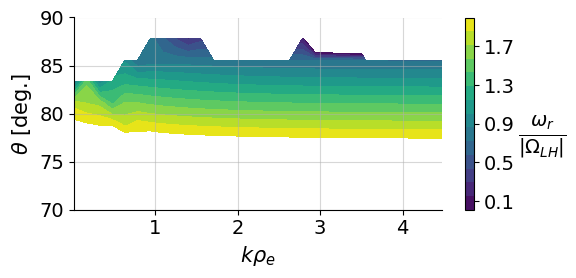

In [23]:
fig, ax = plt.subplots(figsize=(6, 3))
pos = ax.contourf(k_mtsi*rhoe, theta_mtsi*180/np.pi, sol_mtsi.real.T /wLH, 
                  vmin=1e-5, vmax=2, levels=np.linspace(1e-2, 2, 15))
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel(r'$\frac{\omega_{r}}{|\Omega_{LH}|}$', labelpad=20, rotation=0, fontsize=20)
ax.set_xlabel(r'$k \rho_{e}$', fontsize=15)
ax.set_ylabel(r'$\theta$ [deg.]', fontsize=15)
cbar.set_ticks([0.1, 0.5, 0.9, 1.3,  1.7])

#ax.set_xticks([180, 200, 220, 240])
#ax.set_xlim(175, 245)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid(alpha=0.5)
plt.tight_layout()
# plt.savefig("figures/linear_theory/MTSI/omega_r_VD_" + str(round(UDp/alpha_p_par, 1)) + "_mpme_" + str(round(mp_me))+ ".png", dpi=300, bbox_inches='tight')

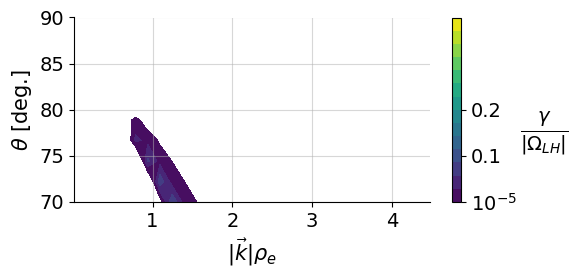

In [24]:
fig, ax = plt.subplots(figsize=(6, 3))

pos_mtsi = ax.contourf(k_mtsi*rhoe, theta_mtsi*180/np.pi,
                sol_mtsi.imag.T * np.sqrt(mp_me), vmin=1E-5, vmax=0.4, levels=np.linspace(1e-5, 0.4, 15))

cbar = fig.colorbar(pos_mtsi)
cbar.ax.set_ylabel(r'$\frac{\gamma}{|\Omega_{LH}|}$', labelpad=20, rotation=0, fontsize=20)
ax.set_xlabel(r'$|\vec{k}| \rho_{e}$', fontsize=15)
ax.set_ylabel(r'$\theta$ [deg.]', fontsize=15)
cbar.set_ticks([1e-5, 0.1, 0.2])
cbar.set_ticklabels(["$10^{-5}$", "0.1", "0.2"])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid(alpha=0.5)
plt.tight_layout()

# plt.savefig("figures/linear_theory/MTSI/gamma_VD_" + str(round(UDp/alpha_p_par, 1))  + "_mpme_" + str(round(mp_me))+ ".png", dpi=300, bbox_inches='tight')

# Plot both instabilities 

NameError: name 'k_perp_mtsi' is not defined

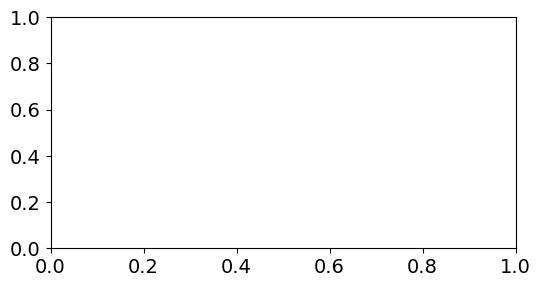

In [42]:
fig, ax = plt.subplots(figsize=(6, 3))


# pos_ii = ax.contourf(k_perp_ii*rhoe, k_par_ii*rhoe, sol_ii.imag.T / wLH,
#                   vmin=1E-5,  vmax=0.4, levels=np.linspace(1e-5, 0.4, 15))

pos_mtsi = ax.contourf(k_perp_mtsi*alpha_c_perp/np.sqrt(2), k_par_mtsi*alpha_c_perp/np.sqrt(2),
                sol_mtsi.imag.T * np.sqrt(mp_me), vmin=1E-5, vmax=0.4, levels=np.linspace(1e-5, 0.4, 15))

cbar = fig.colorbar(pos_mtsi)
cbar.ax.set_ylabel(r'$\frac{\gamma}{|\Omega_{LH}|}$', labelpad=20, rotation=0, fontsize=20)
ax.set_ylabel(r'$k_{\|}\rho_{e}$', fontsize=15)
ax.set_xlabel(r'$k_{\perp}\rho_{e}$', fontsize=15)
cbar.set_ticks([1e-5, 0.1, 0.2])
cbar.set_ticklabels(["$10^{-5}$", "0.1", "0.2"])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid(alpha=0.5)
plt.tight_layout()
